In [1]:
# Package
from __future__ import print_function  
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm
# from mpi4py import MPI
import time
import os 
import glob
from argparse import ArgumentParser
from evolutionSearch import *
from mnist_utils import *
import numpy as np

In [2]:
# MASTER_RANK = 0
device = torch.device("cuda:0")

In [3]:
def crossover(population, prob_crossover=0.8):
    new_population = []
    for i, hparams_1 in enumerate(population):
        if random.uniform(0, 1) <= prob_crossover:
            idx_2 = random.choice([j for j in range(len(population)) if j != i])
            hparams_2 = population[idx_2]
            num_rv_from_h1 = random.randint(1, len(hparams_1))
            rvs = []
            for i in range(len(hparams_1)):
                if i < num_rv_from_h1:
                    rvs.append(hparams_1[i].copy())
                else:
                    rvs.append(hparams_2[i].copy())
            child = HyperParams(rvs)
            new_population.append(child)
    return new_population

def mutation(population, prob_mutation=0.2):
    new_population = []
    for hparams in population:
        new_rvs = []
        for i, rv in enumerate(hparams.rvs):
            if random.uniform(0, 1) <= prob_mutation:
                if isinstance(rv, CRV):
                    mean = rv.value
                    std = np.std( [h.rvs[i].value for h in population] )
                    rv_new = rv.copy()
                    rv_new.value = np.random.normal(mean, std, 1).clip(
                        rv.low, rv.high).item()
                    new_rvs.append(rv_new)
                if isinstance(rv, DRV):
                    rv_new = rv.copy()
                    rv_new.value = random.choices(rv.choices)[0]
                    new_rvs.append(rv_new)
            else:
                new_rvs.append(rv.copy())
        hparams_new = HyperParams(new_rvs)
        if hparams_new != hparams:
            new_population.append(hparams_new)
    return new_population

In [4]:
def evaluate_popuation(population, mpiWorld, pbars):
    local_population = population
    local_fitness = []
    # Evaluate HyperParameters
    for i, hparams in enumerate(local_population):
        # if mpiWorld.isMaster():
        if True:
            pbars['search'].set_postfix({
                "Best":"{:.2f}%".format(get_best_acc(resultDict)), 
                "Progress":"({}/{})".format(i+1, len(local_population))
            })

        # Get Hyper-Parameters
        lr, dr = hparams[0].value, hparams[1].value
        # Train MNIST
        #acc = train_mnist(lr=lr, dr=dr, device=device, pbars=pbars)
        acc = train_mnist(lr=lr, mmt=dr, device=device, pbars=pbars)
        # acc = 1 - (lr-0.052)**2 - (dr-0.25)**2
        local_fitness.append(acc)
        
    return local_population, local_fitness

def get_unevaluated_population(population, resultDict):
    #if mpiWorld.isMaster():
    if True:
        unevaluated_population = []
        for hyperparams in population:
            key = hyperparams
            if key not in resultDict:
                unevaluated_population.append(hyperparams)
        return unevaluated_population
    else:
        return None

def generation(population, mpiWorld, resultDict, pbars):
    population_dict = {}
    #if mpiWorld.isMaster():
    if True:
        population_dict['start'] = population
        population_size = len(population)

        # === 1. Crossover === #
        population_crossover = crossover(population)
        population_dict['crossover'] = population_crossover
        population += population_crossover
        # print("\n", population_size, len(population), "\n")

        # ===  2. Mutation === #
        population_mutation = mutation(population)
        population_dict['mutation'] = population_mutation
        population += population_mutation 
        population = list(set(population))
        # print("\n", population_size, len(population), "\n")

    # === 3. Selcetion === #
    # Evaluate Unevaluated Hypermeters  
    unevaluated_population = get_unevaluated_population(population, resultDict)
    unevaluated_population, fitness = evaluate_popuation(
        unevaluated_population, mpiWorld, pbars)
    #if mpiWorld.isMaster():
    if True:
        # Update resultDict
        for hparams, acc in zip(unevaluated_population, fitness):
            if hparams not in resultDict:
                key = hparams
                resultDict[key] = acc
                # resultDict[key] = hparams[0].value
        # Select best
        scores = []
        for hparams in population:
            key = hparams
            scores.append(resultDict[key])
        sort_idx = np.argsort(scores)
        scores = [scores[i.item()] for i in sort_idx][-population_size:][::-1]
        population = [population[i.item()] for i in sort_idx][-population_size:][::-1]
        population_dict['selcetion'] = population
    return population_dict

def get_best_acc(resultDict):
    best_acc = 0.0
    for hparams, acc in resultDict.items():
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [5]:
# REPRODUCIBILITY
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# batch_size = 512
# population_size = 16
# lr = CRV(low=0, high=0.5, name="learning rate")
# dr = CRV(low=0, high=1, name="dropout rate")
# num_generation = 18

In [6]:
population = []
resultDict = {}
# Init Population
population_size = 10
for i in range(population_size):
    lr  = CRV(low=0, high=1.0, name="learning rate")
    dr  = CRV(low=0, high=1.0, name="dropout rate")
    mmt = CRV(low=0, high=1.0, name="momentum")
    hparams = HyperParams([lr, mmt])
    population.append(hparams)

In [7]:
mpiWorld = None

In [8]:
num_generation = 18

pbars = {"search":tqdm(ncols=800, total=num_generation, unit='generation'), 
         "train":tqdm(ncols=1000), 
         "test":tqdm(ncols=1000)}
pbars['search'].set_description("Evolutionary Search")
population_each_generation = []

for g in range(1, num_generation+1):
    population_dict = generation(population, mpiWorld, resultDict, pbars)
    
    pbars['search'].update()
    population_each_generation.append(population_dict)
    population = population_dict["selcetion"]
#     np.set_printoptions(suppress=True)
#     print( "{:.8f},{:.8f}".format(np.mean([h[0].value for h in population]), 
#       np.std([h[0].value for h in population]) ) )

In [9]:
def vis_population(population, label="", c=None, s=None, marker=None):
    if len(population) == 0:
        return 
    xs = [hparams.rvs[0].value for hparams in population]
    ys = [hparams.rvs[1].value for hparams in population]
    if c is not None:
        plt.scatter(xs, ys, label=label, c=c, s=s, marker=marker)
    else:
         plt.scatter(xs, ys, label=label)
    if isinstance(population[0].rvs[0], DRV):
        plt.xticks(list(set(xs)))
    if isinstance(population[0].rvs[1], DRV):
        plt.yticks(list(set(ys)))

No handles with labels found to put in legend.


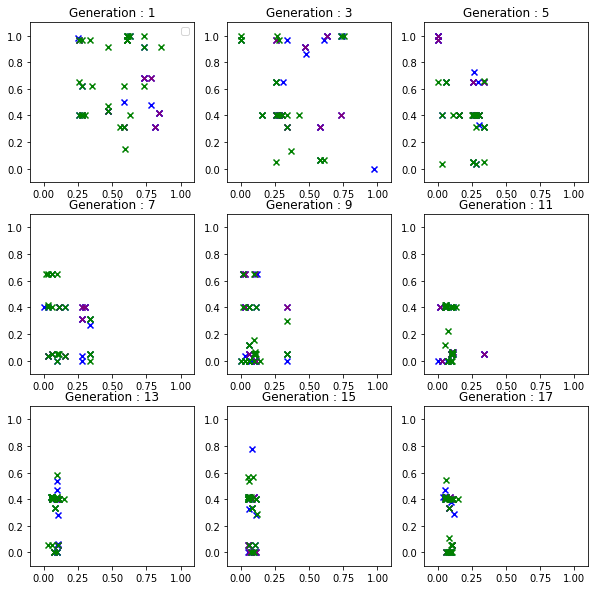

[(HyperParams:learning rate=0.1039,momentum=0.0530,),
 (HyperParams:learning rate=0.0556,momentum=0.4143,),
 (HyperParams:learning rate=0.0570,momentum=0.4049,),
 (HyperParams:learning rate=0.0923,momentum=0.0000,),
 (HyperParams:learning rate=0.0747,momentum=0.0000,),
 (HyperParams:learning rate=0.0813,momentum=0.3306,),
 (HyperParams:learning rate=0.1096,momentum=0.4049,),
 (HyperParams:learning rate=0.0592,momentum=0.4143,),
 (HyperParams:learning rate=0.0955,momentum=0.0530,),
 (HyperParams:learning rate=0.0960,momentum=0.0000,)]

In [10]:
plt.figure(figsize=(10,10))
offset = len(population_each_generation) / 9
display_idx = [int(i*offset) for i in range(9)]
for cnt, i in enumerate(display_idx):
    plt.subplot(3, 3, cnt+1)
    vis_population(population_each_generation[i]['start'], 
                   c='blue', marker="x")
    vis_population(population_each_generation[i]['crossover'], 
                   c='purple', marker="x")
    vis_population(population_each_generation[i]['selcetion'], 
                   c='green', marker="x")
    if cnt ==0:
        plt.legend(loc='best')
    offset = 0.1
    plt.xlim(population[0][0].low-offset, population[0][0].high+offset)
    plt.ylim(population[0][1].low-offset, population[0][1].high+offset)
    plt.title("Generation : {}".format(i+1))
plt.show()
population_each_generation[-1]['selcetion']

155


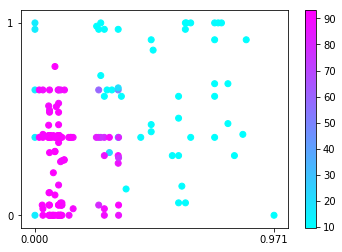

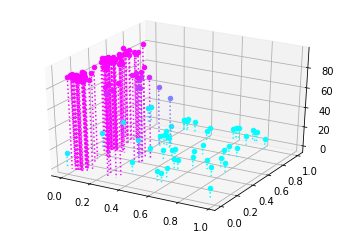

In [11]:
hyperparams = []
results = []
for hparams, acc in resultDict.items():
    lr, dr = hparams[0].value, hparams[1].value 
    hyperparams.append((lr, dr))
    results.append(acc)
vis_search(hyperparams, results)
print(len(resultDict))